In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import clip
import re
import time
import yaml
import os
from matplotlib import pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer
from networks import SCLIPNN, SCLIPNN3

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading Models")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_model.eval()

Loading Models


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [3]:
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
params = cfg["training"]

In [4]:
def get_files_paths(directory):
    train_txt = 'train_sentences.txt'    
    valid_txt = 'valid_sentences.txt'
    test_txt = 'test_sentences.txt'
    train_path = os.path.join(directory,train_txt)    
    valid_path = os.path.join(directory,valid_txt)
    test_path  = os.path.join(directory, test_txt)
    return train_path, valid_path, test_path
    
def get_sentences_from_file(filename):
    sentences = []
    with open(filename, mode='rt', encoding='utf-8') as file_object:
        for line in file_object:
            sentences.append(line)    
    return sentences

In [5]:
def regexification(sentences):
    regex = [r"[^A-Za-z0-9]+|[a-zA-Z][0-9]", r"(?<!\d)[0]\d*(?!\d)", r"\s+", r"[0-9]+"]
    for r in regex:
        sentences = list(map(lambda sentence: re.sub(r, " ", sentence), sentences))
    return sentences

def get_clip_embeddings(sentences):
    tokenized_text = clip.tokenize(sentences).to(device)
    with torch.no_grad():
        clip_embeddings = clip_model.encode_text(tokenized_text)
        clip_embeddings.to('cpu')
    return clip_embeddings

def get_sbert_embeddings(sentences):
    with torch.no_grad():  
        sbert_embeddings = torch.from_numpy(sbert_model.encode(sentences))
    return sbert_embeddings

In [6]:
def show_embeddings_return_size(sentences, clip_embeddings, sbert_embeddings):
    ("-"*10)
    for sentence, clip_embedding, sbert_embedding in zip(sentences[:1], clip_embeddings[:1], sbert_embeddings[:1]):
        print("Sentence:", sentence)
        input_size = sbert_embedding.size()[0]    
        print("Sbert Embedding: ", input_size)
        print("Clip Embedding: ", clip_embedding.size()[0])
        print("-"*10)
    return input_size

In [7]:
def get_models_to_train(input_size):
    print("Creating Models to train...")
    NN_700 = SCLIPNN(input_size, 700).to(device)
    NN_800 = SCLIPNN(input_size, 800).to(device)
    NN3_700 = SCLIPNN3(input_size, 700).to(device)
    NN3_800 = SCLIPNN3(input_size, 800).to(device)
    models = {'NN_700':NN_700, 'NN3_700':NN3_700,
              'NN_800':NN_800, 'NN3_800':NN3_800}
    print(f'{len(models)} models created.')
    return models

In [8]:
def show_plot(models,model_train_losses,model_valid_losses):
    rows = 2
    columns = int((len(models)+1)/2)
    fig, axs = plt.subplots(rows,columns,figsize=(18,10))
    positions = []
    for r in range(rows):
        for c in range(columns):
            positions.append((r,c))
    for i, (name, model) in enumerate(models.items()):
        axs[positions[i]].plot(model_train_losses[i][1:], label = 'train '+ name)
        axs[positions[i]].plot(model_valid_losses[i][1:], label = 'valid '+ name, marker = '*')
        axs[positions[i]].set_title('Losses of '+ name)
        axs[positions[i]].grid()
        axs[positions[i]].legend()
    
    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Loss')
    
    #fig.legend()
    #fig.title('Losses per Epoch')
    
    plt.show()

In [9]:
class EmbeddingsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        if len(self.X) != len(self.Y):
            raise Exception("The length of X does not match the length of Y")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        item_x = self.X[index]
        item_y = self.Y[index]
        return item_x, item_y

In [10]:
def train(model, train_dataset, valid_dataset, b_size=32, epochs=params["epochs"], print_every=params["print_every"]):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)    
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        model.train()
        train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=b_size, shuffle=True)
        train_counter = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.to(float), labels.to(float))       
            loss.backward()
            optimizer.step()
            train_loss += loss.item()         
            train_counter += 1
        train_losses.append(train_loss/train_counter)
        
        valid_loss = 0.0
        model.eval()
        valid_counter = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            target = model(inputs)
            loss = criterion(target.to(float), labels.to(float))
            valid_loss += loss.item()
            valid_counter += 1
        valid_losses.append(valid_loss/valid_counter)
        if (epoch % print_every == 0) or (epoch == epochs - 1):
            print("Epoch {}. Train Loss: {}. Valid Loss: {}".format(epoch, train_loss/train_counter, valid_loss/valid_counter))
    return train_losses, valid_losses

In [11]:
def supra_training(models,train_sbert_emb,train_clip_emb,valid_sbert_emb, valid_clip_emb, trainset):
    model_train_losses = []
    model_valid_losses = []
    final_loss = []
    training_time = []
    for name, model in models.items():
        start_time = time.time()
        train_dataset = EmbeddingsDataset(train_sbert_emb, train_clip_emb)
        valid_dataset = EmbeddingsDataset(valid_sbert_emb, valid_clip_emb)
        train_loss, valid_loss = train(model, train_dataset, valid_dataset)
        torch.save(model.state_dict(), os.path.join('models',trainset + '_' + name + '.pt'))
        model_train_losses.append(train_loss)                   
        model_valid_losses.append(valid_loss)
        final_loss.append(round(valid_loss[-1],3))
        end_time = time.gmtime(time.time() - start_time)
        elapsed_time = time.strftime("%H:%M:%S", end_time)
        training_time.append(elapsed_time)
        print('Finished Training from model {}. Elapsed time: {}.'.format(name,elapsed_time))
        #print("-"*50)        
    actual_time = time.strftime("%Y/%m/%d, %H:%M:%S", time.gmtime(time.time()))
    print("End of Training Process on {}".format(actual_time))
    return model_train_losses, model_valid_losses, training_time, final_loss

In [12]:
def get_train_embeddings(directory):
    train_file, valid_file, test_file = get_files_paths(directory)
    train_sentences = regexification(get_sentences_from_file(train_file))
    valid_sentences = regexification(get_sentences_from_file(valid_file))
    print("CLIP encoding...")
    train_clip_embeddings = get_clip_embeddings(train_sentences)
    valid_clip_embeddings = get_clip_embeddings(valid_sentences)
    print("SBERT encoding...")
    train_sbert_embeddings = get_sbert_embeddings(train_sentences)
    valid_sbert_embeddings = get_sbert_embeddings(valid_sentences)
    return train_clip_embeddings, valid_clip_embeddings, train_sbert_embeddings, valid_sbert_embeddings

In [13]:
def get_test_embeddings(directory):
    train_file, valid_file, test_file = get_files_paths(directory)
    test_sentences = regexification(get_sentences_from_file(test_file))
    print("CLIP encoding...")
    test_clip_embeddings = get_clip_embeddings(test_sentences)
    print("SBERT encoding...")
    test_sbert_embeddings = get_sbert_embeddings(test_sentences)
    return test_clip_embeddings, test_sbert_embeddings

In [14]:
def cosin_calculator(targets, predictions):    
    cosines = []
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    for tar, pred in zip(targets, predictions):        
        cosine = cos(tar, pred)
        cosines.append(cosine.item())
    return np.array(cosines)

In [15]:
def evaluate(models, test_clip_embeddings, test_sbert_embeddings,trainset):
    cosines = []
    euclideans = []
    with torch.no_grad():
        for name, model in models.items():
            path = os.path.join('models',trainset + '_' + name+'.pt')
            input_size = test_sbert_embeddings[0].size()[0]
            if 'NN3' in name:
                loaded_model = SCLIPNN3(input_size,int(name[-3:])).to(device)
            else:
                loaded_model = SCLIPNN(input_size,int(name[-3:])).to(device)
            loaded_model.load_state_dict(torch.load(path))            
            sum_cos = 0
            count = 0
            predictions =[]
            if len(test_clip_embeddings) == 0:
                print('len(test_clip_embeddings) == 0. Breaking')
                break
            for tclip, tsbert in zip(test_clip_embeddings, test_sbert_embeddings):        
                tclip = tclip.to(device)
                tsbert = tsbert.to(device)
                prediction = loaded_model(tsbert)
                predictions.append(prediction)
                sum_cos += np.mean(cosin_calculator(tclip, prediction))
                count += 1
            cosines.append(round(sum_cos/count,3))
            stacked_predictions = torch.stack(predictions)
            euclidean = torch.cdist(test_clip_embeddings.to(float), stacked_predictions.to(float))
            avg_euclidean = torch.mean(euclidean)
            euclideans.append(round(avg_euclidean.item(),3))    
    return cosines, euclideans

In [16]:
### Training Pipeline
durations = {}
finals = {}
train_clip_emb, valid_clip_emb, train_sbert_emb, valid_sbert_emb = get_train_embeddings(directory)
input_size = train_sbert_emb[0].size()[0]
models = get_models_to_train(input_size)

Training on europarl dataset
CLIP encoding...
SBERT encoding...
Creating Models to train...
4 models created.


Epoch 0. Train Loss: 0.23993674183603056. Valid Loss: 0.2348360062655832
Epoch 50. Train Loss: 0.046901097407293084. Valid Loss: 0.04863661563522415
Epoch 100. Train Loss: 0.04621831803633337. Valid Loss: 0.048050609127295675
Epoch 149. Train Loss: 0.04601982001377575. Valid Loss: 0.04784848046744364
Finished Training from model NN_700. Elapsed time: 00:01:36.
Epoch 0. Train Loss: 0.2405673741016583. Valid Loss: 0.23550597175302562
Epoch 50. Train Loss: 0.0462794746001806. Valid Loss: 0.04813647323501065
Epoch 100. Train Loss: 0.046096210644531094. Valid Loss: 0.047973752031319525
Epoch 149. Train Loss: 0.0459376820533783. Valid Loss: 0.047861845859995235
Finished Training from model NN3_700. Elapsed time: 00:01:52.
Epoch 0. Train Loss: 0.2410215916368658. Valid Loss: 0.23575592833548092
Epoch 50. Train Loss: 0.046916083620032654. Valid Loss: 0.04866119996032667
Epoch 100. Train Loss: 0.0463195085186063. Valid Loss: 0.04816628892032642
Epoch 149. Train Loss: 0.04611709675069779. Valid 

,TrainLoss,ValidLoss
NN_700,0.046020,0.048
NN3_700,0.045938,0.048
NN_800,0.046117,0.048
NN3_800,0.045951,0.048


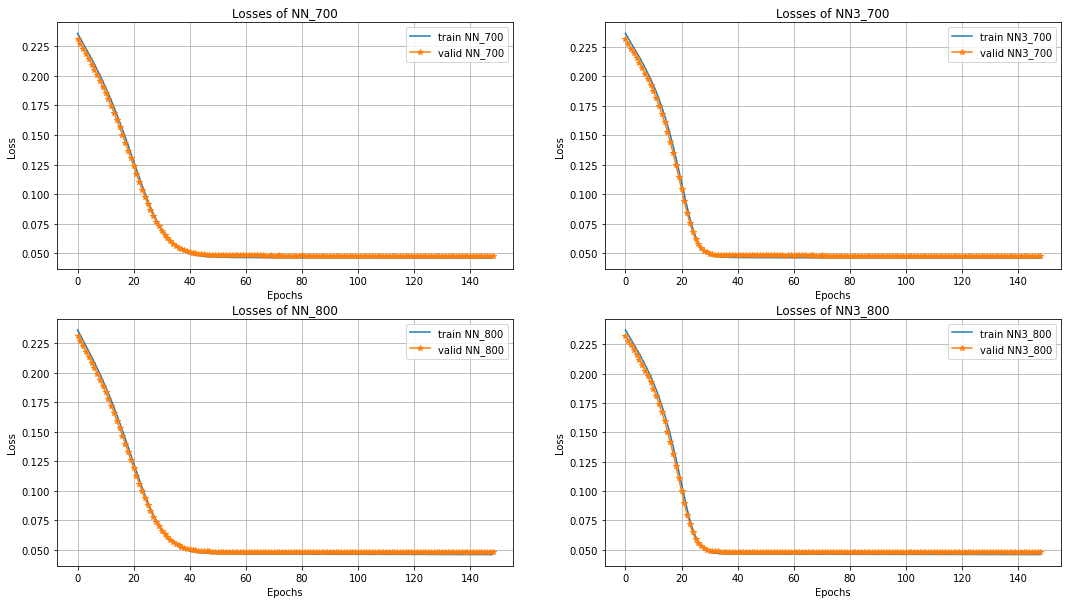

In [17]:
directories = ['europarl','coco']
for directory in directories:
    print(f'Training on {directory} dataset')
    train_losses, valid_losses, train_time,final_loss = supra_training(models,train_sbert_emb,train_clip_emb, valid_sbert_emb, valid_clip_emb,trainset=directory)
    durations[directory] = train_time
    finals[directory] = final_loss
    train_final_losses = [x[-1] for x in train_losses]
    train_results = pd.DataFrame({"TrainLoss":train_final_losses, "ValidLoss":final_loss}, index=models.keys())
    display(train_results)
    show_plot(models,train_losses,valid_losses)

In [20]:
print("Evaluating...")
directories = ['europarl','coco'] #params['test_dataset']
for directory in directories:
    print(f'Evaluating with test dataset {directory}...')    
    test_clip_emb, test_sbert_emb = get_test_embeddings(directory)
    for train_directory in directories:
        print(f'...the model trained on {train_directory}')
        start_time = time.time()
        cosines, euclideans = evaluate(models,test_clip_emb, test_sbert_emb,trainset=train_directory)
        end_time = time.gmtime(time.time() - start_time)
        evaluation_time = time.strftime("%H:%M:%S", end_time)
        print("Evaluation Time: {}".format(evaluation_time))
        data = {"Cosin":cosines, "Euclidean":euclideans, 
                "TrainTime":durations[directory], "ValLoss":finals[directory]}
        results = pd.DataFrame(data, index=models.keys())
        display(results)
print("End of Evaluation")

Evaluating...
Evaluating dataset europarl
CLIP encoding...
SBERT encoding...
Evaluation Time: 00:19:01


,Cosin,Euclidean,TrainTime,ValLoss
NN_700,0.277,5.010,00:01:36,0.048
NN3_700,0.277,5.001,00:01:52,0.048
NN_800,0.275,5.011,00:01:36,0.048
NN3_800,0.277,5.001,00:01:51,0.048


End of Evaluation
